* INCLUDE mixed donor sample
* REMOVED 5-prime sample
* Add lower filtering threshhold for 'total_counts' (not only 'n_genes')
* Add AVN samples 

## Import modules

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scrublet as scr
import session_info

In [2]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')
session_info.show()

## Read in anndata

In [3]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/QC/snRNA_adult_prefilter.h5ad')
adata

AnnData object with n_obs × n_vars = 464734 × 33538
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval'
    var: 'gene_name', 'ambient_expression-0', 'feature_type-0', 'ambient_expression-1', 'feature_type-1', 'ambient_expression-10', 'feature_type-10', 'ambient_expression-11', 'feature_type-11', 'ambient_expression-12', 'feature_type-12', 'ambient_expression-13', 'feature_type-13', 'ambient_expression-14', 'feature_type-14', 'ambient_expression-15', 'feature_type-15', 'ambient_expression-16', 'feature_type-16', 'ambient_expression-17', 'feature_type-17', 'ambient_expression-18', 'feature_type-18', 'ambient_expression-19', 'feature_type-19', 'ambient_expression-2', 'feature_type-2', 'ambient_expression-20', 'feat

In [4]:
adata.obs['sangerID'].value_counts()

H0020_LV           13327
H0025_LV           12932
H0026_LV           11243
H0035_RV           10699
H0015_LV           10530
                   ...  
HCAHeart7757637     1364
HCAHeart8287123      631
HCAHeart8287124      360
HCAHeart8287125      272
HCAHeart7757638      211
Name: sangerID, Length: 94, dtype: int64

## Remove doublets

<AxesSubplot:>

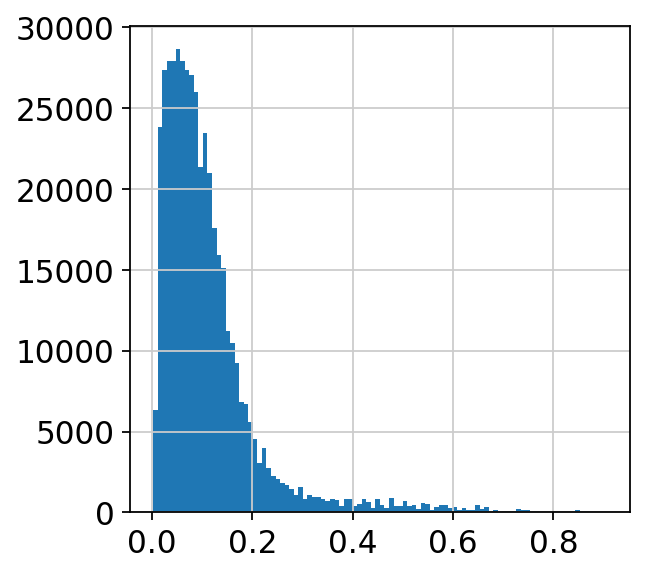

In [5]:
adata.obs['scrublet_score'].hist(bins=100)

In [6]:
# set threshold (arbitrary)
dbl_score_thresh=0.3

prop = np.sum(adata.obs['scrublet_score']>=dbl_score_thresh)/len(adata)
print(f'proportion of doublets: {prop}')

proportion of doublets: 0.049985583150791636


In [7]:
# Remove doublets
adata = adata[adata.obs['scrublet_score']<dbl_score_thresh]
adata

View of AnnData object with n_obs × n_vars = 441293 × 33538
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval'
    var: 'gene_name', 'ambient_expression-0', 'feature_type-0', 'ambient_expression-1', 'feature_type-1', 'ambient_expression-10', 'feature_type-10', 'ambient_expression-11', 'feature_type-11', 'ambient_expression-12', 'feature_type-12', 'ambient_expression-13', 'feature_type-13', 'ambient_expression-14', 'feature_type-14', 'ambient_expression-15', 'feature_type-15', 'ambient_expression-16', 'feature_type-16', 'ambient_expression-17', 'feature_type-17', 'ambient_expression-18', 'feature_type-18', 'ambient_expression-19', 'feature_type-19', 'ambient_expression-2', 'feature_type-2', 'ambient_expression-20

## Remove low quality cells

In [8]:
sc.pp.filter_cells(adata, min_genes=200, inplace=True)
sc.pp.filter_cells(adata, min_counts=500, inplace=True)
adata.shape

filtered out 20385 cells that have less than 200 genes expressed
Trying to set attribute `.obs` of view, copying.
filtered out 44371 cells that have less than 500 counts


(376537, 33538)

## Compute QC stats

In [9]:
adata.var['mt'] = adata.var['gene_name'].str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var['gene_name'].str.startswith('RPS','RPL')  # annotate the group of ribosomal genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)

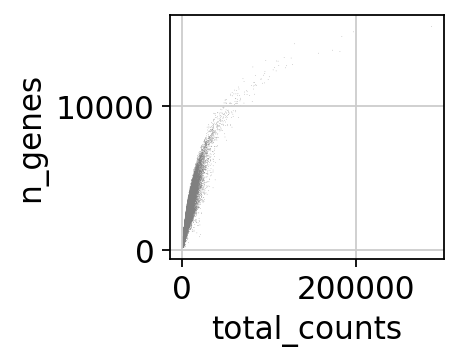

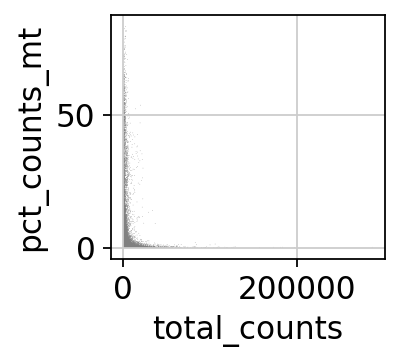

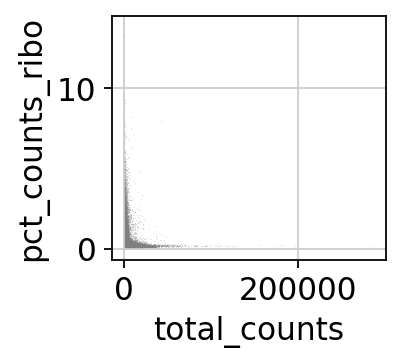

In [10]:
plt.rcParams['figure.figsize'] = [3, 2]

sc.pl.scatter(adata, x='total_counts', y='n_genes')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo')

## Remove cells exceeding the ribo/mito threshold

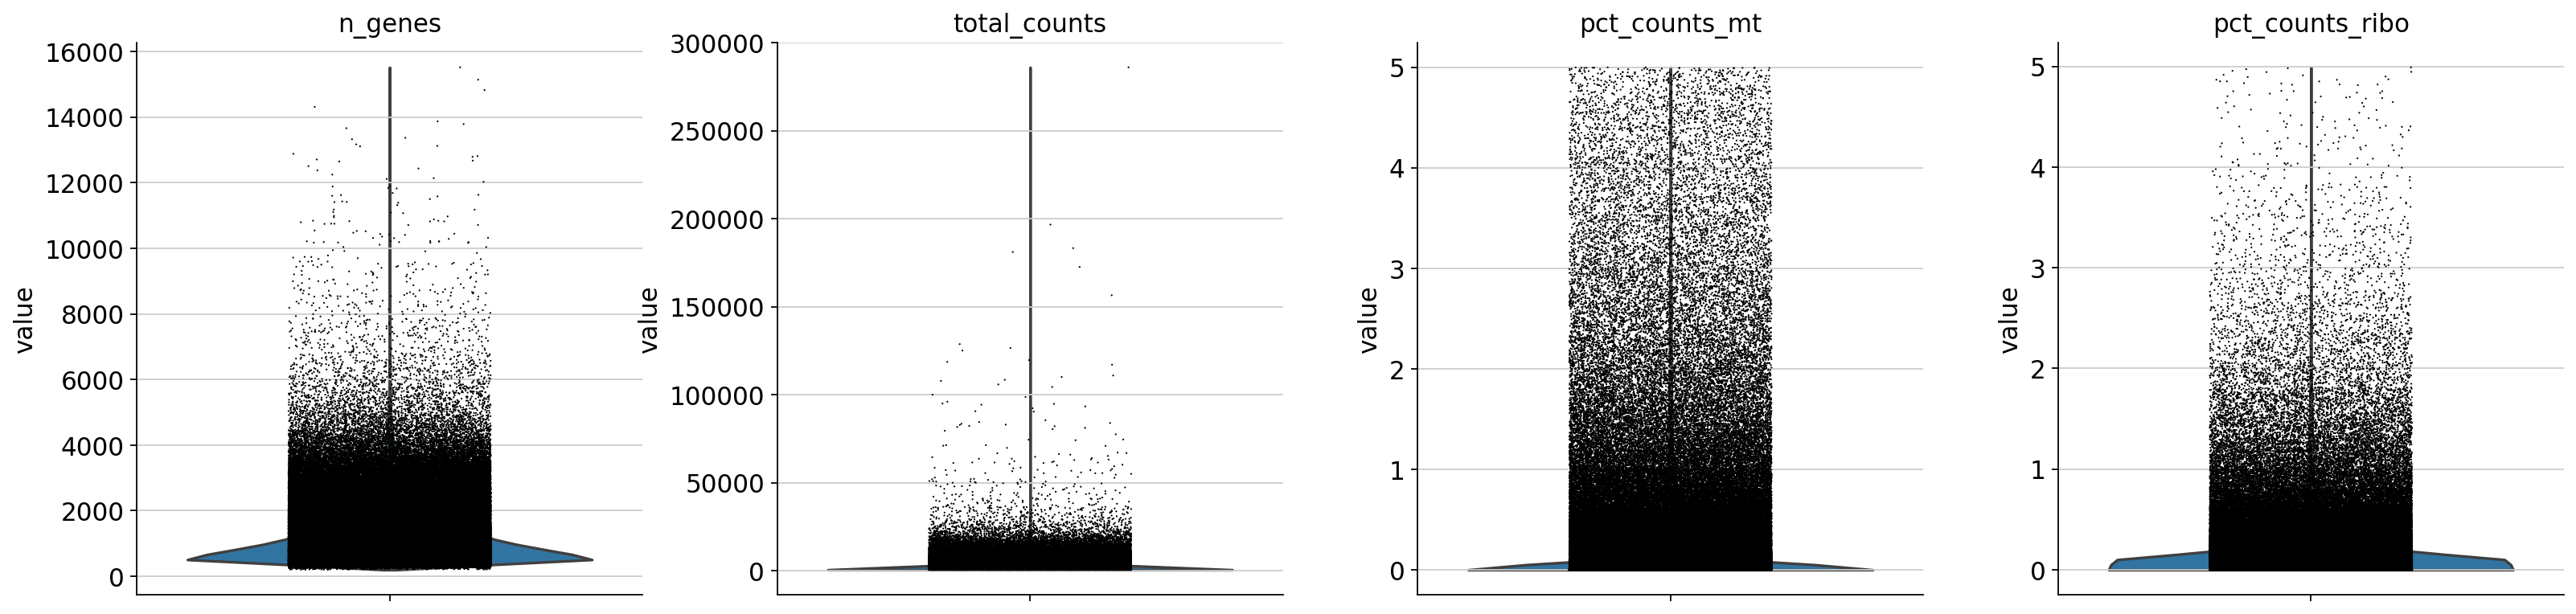

In [11]:
plt.rcParams['figure.figsize'] = [2, 2]
adata = adata[adata.obs['pct_counts_mt'] < 5, :]
adata = adata[adata.obs['pct_counts_ribo'] < 5, :]
sc.pl.violin(adata, ['n_genes', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter = 0.2, multi_panel = True)

In [12]:
adata.shape

(369099, 33538)

## Save

In [13]:
adata.write('/nfs/team205/heart/anndata_objects/8regions/QC/snRNA_adult.h5ad')

In [14]:
adata.obs['donor'].value_counts()

D2     45881
H5     39576
H3     34169
H7     33184
H6     28726
D4     27093
H4     26613
H2     22959
D5     22860
D3     22757
D6     18203
D7     17355
D1     15757
D11    13966
Name: donor, dtype: int64